First we will import our datasets in. 

Please refer to instructions included with this submission for the .csv files to upload. There are 4 different datasets required.

In [ ]:
from google.colab import drive, files

#Set to true to manually upload the csvs, false to use those in your google drive
upload= True

#Set true to use the dataset; false will use the weekly dataset
daily = False

if upload:
  uploaded = files.upload()
else:
  drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Data Preprocessing

We will define a preprocessing function here that mainly cleans the data by removing unnescessary regions, formats data, collapses into weekly metrics, and performs imputation/normalization as defined in our report



In [ ]:
import math
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler, normalize

def preprocessing(hosp_cases_df, search_trends_df, daily_searches_df, pop_estimate_df,  daily=False):
  if daily:
    searches_df = daily_searches_df
  else:
    searches_df = search_trends_df

  #removing unneeded region info columns
  del searches_df['country_region']
  del searches_df['country_region_code']
  del searches_df['sub_region_1']
  del searches_df['sub_region_1_code']
  del searches_df['sub_region_2']
  del searches_df['sub_region_2_code']

  columns_to_keep_hosp_df = set(['open_covid_region_code','date','hospitalized_cumulative','hospitalized_new'])

  for column in hosp_cases_df.columns:
    if column not in columns_to_keep_hosp_df:
      del hosp_cases_df[column]

  # remove all columns with all empty cells
  searches_df.dropna(how='all',axis='columns',inplace=True)
  hosp_cases_df.dropna(how='all',axis='columns',inplace=True)

  # keep only regions that starts with "US-"
  hosp_cases_df = hosp_cases_df[hosp_cases_df['open_covid_region_code'].str.startswith('US-',na=False)]

  #Remove the US- from that column in hosp dataset and search datyaset
  hosp_cases_df['open_covid_region_code'] = hosp_cases_df['open_covid_region_code'].str[3:]
  searches_df['open_covid_region_code'] = searches_df['open_covid_region_code'].str[3:]

  #Remove symptom: from the columns names for display purposes
  searches_df.columns = searches_df.columns.str.replace("symptom:",'')

  # Collapse cleaned hosp cases to weekly data starting 2020-03-09 (Monday)
  hosp_cases_weekly_list = []
  hosp_cases_weekly_info = []
  monday_index = 0
  monday_date = ''
  hosp_new_sum = 0
  region_counting_started = False
  reset = False
  for index, row in hosp_cases_df.iterrows():
    if row['date'] == '2020-03-09':
      region_counting_started = True
      reset = True
      monday_index = index
      monday_date = row['date']
    if region_counting_started: # If it's outside the range of 2020-03-09 to 2020-09-27, we don't care about that data
      if reset:
        monday_index = index
        monday_date = row['date']
        hosp_new_sum = 0
        hosp_cases_weekly_info = []
        reset = False

      hosp_new_sum += int(row['hospitalized_new'])
      if index - monday_index == 6: # Finished counting for 1 week
        reset = True
        hosp_cases_weekly_info.append(row['open_covid_region_code'])
        hosp_cases_weekly_info.append(monday_date)
        hosp_cases_weekly_info.append(row['hospitalized_cumulative'])
        hosp_cases_weekly_info.append(hosp_new_sum)
        hosp_cases_weekly_list.append(hosp_cases_weekly_info)
      if row['date'] == '2020-09-27':
        region_counting_started = False

  hosp_cases_weekly_df = pd.DataFrame(hosp_cases_weekly_list, columns = ['open_covid_region_code', 'date', 'hospitalized_cumulative', 'hospitalized_new'])

  hosp_cases_weekly_df['date'] = hosp_cases_weekly_df['date'].astype('datetime64[ns]')

  # Collapse data into weekly
  searches_df['date'] = searches_df['date'].astype('datetime64[ns]')
  if daily:
    search_trends_df = searches_df.groupby('open_covid_region_code').resample('W-Mon', label='right', closed = 'right', on='date').mean().reset_index().sort_values(by='date')

  # Split the df into regions, and remove those with too many missing values
  names=search_trends_df['open_covid_region_code'].unique().tolist()
  if daily:
    threshold = 0.25
  else:
    threshold = 0.60
  for name in names:
      state = search_trends_df.loc[search_trends_df.open_covid_region_code==name]
      nulls = state.isnull().sum().sum()
      rationulls = nulls / (state.shape[0] * state.shape[1])
      if rationulls >= threshold:
        search_trends_df.drop(search_trends_df.loc[search_trends_df['open_covid_region_code']==name].index, inplace=True)

  # Drop columns with too many NaNs
  if daily:
    threshold = 0.20
  else:
    threshold = 0.30
  num_rows = len(search_trends_df.index)
  num_of_rows_to_drop = math.ceil(threshold * num_rows)
  search_trends_df.dropna(axis="columns", thresh=num_of_rows_to_drop, inplace=True)

  # Drop columns that are deemed noise
  if daily:
    noise_threshold = 0
  else:
    noise_threshold = 5
  for index, value in search_trends_df.mean().items():
    if value <= noise_threshold:
      search_trends_df = search_trends_df.drop(index, axis=1)

  # Fill the NaNs with the mean or 0 if the region does not have a mean for the column
  names=search_trends_df['open_covid_region_code'].unique().tolist()
  all_states = []
  for name in names:
      state = search_trends_df.loc[search_trends_df.open_covid_region_code==name]
      state = state.fillna(state.mean())
      all_states.append(state)
  search_trends_df = pd.concat(all_states)
  search_trends_df = search_trends_df.fillna(0)

  temp_search_df = search_trends_df

  #normalize data within regions
  all_states=[]
  for name in names:
      state = temp_search_df.loc[temp_search_df.open_covid_region_code==name]
      num_cols = state.columns[state.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
      pop = pop_estimate_df.loc[pop_estimate_df.open_covid_region_code==name]
      state[num_cols]=state[num_cols].apply(lambda x: x*pop['pop_estimate'].values[0])
      all_states.append(state)
  temp_search_df = pd.concat(all_states)
  num_cols = temp_search_df.columns[temp_search_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
  normalize(temp_search_df[num_cols], norm='l2')

  # merge 2 data frames
  merged = temp_search_df.merge(hosp_cases_weekly_df, left_on=['open_covid_region_code','date'], right_on = ['open_covid_region_code','date'])
  merged = merged[merged["hospitalized_new"] > 0]

  return [merged, search_trends_df]

We then call our preprocessing function with paths to our datasets to retrieve all information into a pandas dataframe.

In [ ]:
import pandas as pd
import io 

path_to_dataset_1 = ""
path_to_dataset_2 = "" 
path_to_dataset_3 = ""
path_to_dataset_4 = ""

if upload:
  path_to_dataset_1 = io.BytesIO(uploaded['searchtrends.csv'])
  path_to_dataset_2 = io.BytesIO(uploaded['file.csv'])
  path_to_dataset_3 = io.BytesIO(uploaded['searchtrendsdaily.csv'])
  path_to_dataset_4 = io.BytesIO(uploaded['popestimate.csv'])
else:
  path_to_dataset_1 = "/content/drive/My Drive/MLPROJ1/searchtrends.csv"
  path_to_dataset_2 = "/content/drive/My Drive/MLPROJ1/file.csv"
  path_to_dataset_3 = "/content/drive/My Drive/MLPROJ1/searchtrendsdaily.csv"
  path_to_dataset_4 = "/content/drive/My Drive/MLPROJ1/popestimate.csv"

search_trends_df = pd.read_csv(path_to_dataset_1)
hosp_cases_df = pd.read_csv(path_to_dataset_2)
daily_searches_df = pd.read_csv(path_to_dataset_3)

#https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
pop_estimate_df = pd.read_csv(path_to_dataset_4)

dfs = preprocessing(hosp_cases_df, search_trends_df, daily_searches_df, pop_estimate_df,  daily=daily)
merged = dfs[0]
search_trends_df=dfs[1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.6/dist-packages/pa

**TASK 2 VISUALIZE THE DATA**


2.1 Search trends of most popular symptoms by region

---



Next cell defines the plotting function. All of the regions for which data is available will have a line on the graph which can be toggled on and off by clicking on the line in the legend.

In [ ]:
import plotly.graph_objects as go

#get the unique names of the states
names=search_trends_df['open_covid_region_code'].unique().tolist()

#define the plotting function
def multi_plot(df, title, symptom, addAll = True):
    fig = go.Figure()
    #for each state, plot the search trends vs time of the symptom
    for name in names:
      state = search_trends_df.loc[search_trends_df.open_covid_region_code==name]
      fig.add_trace(
          go.Scatter(
              x = state['date'],
              y = state[symptom],
              name = name
          )
      )

    # Update remaining layout properties
    fig.update_layout(
        title_text=title,
        xaxis_title="Weeks",
        yaxis_title="Normalized search volume",
        height=700
    )
    fig.show()


Now, we can can call this new function to plot graphs corresponding to each symptom. The symptoms can be selected in the drop down menu.

In [ ]:
import ipywidgets as wid
from IPython.display import clear_output

def event_handler(index):
  for i in range(10):
    clear_output(wait=True)
  dropdown_menu(index.new)
  multi_plot(search_trends_df, title="Weekly {} Searches In Different States".format(index.new), symptom=index.new)
  
def dropdown_menu(value):
  dropdown = wid.Dropdown(options=search_trends_df.columns[2:].tolist(), value=value)
  dropdown.observe(event_handler, names="value")
  display(dropdown)
if daily:
  dropdown_menu('Abdominal obesity')
  multi_plot(search_trends_df, title="Weekly {} Searches In Different States".format('Abdominal obesity'), symptom='Abdominal obesity')
else:
  dropdown_menu('Adrenal crisis')
  multi_plot(search_trends_df, title="Weekly {} Searches In Different States".format('Adrenal crisis'), symptom='Adrenal crisis')

Dropdown(options=('Abdominal obesity', 'Abdominal pain', 'Acne', 'Actinic keratosis', 'Acute bronchitis', 'Adr…

2.2 PCA visualization of the search trends

---



pca_95_df shape:  (1800, 3)
pca_85_df shape:  (1800, 2)


Text(0.5, 1.0, 'PCA')

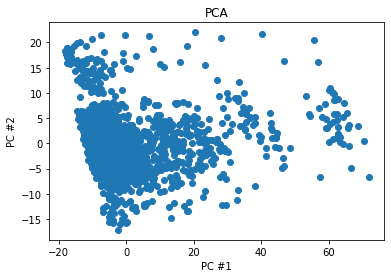

In [ ]:
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#pca = PCA(n_components=2)
pca_95 = PCA(0.95)
pca_85 = PCA(0.85)
pca_df = search_trends_df.drop(columns=['open_covid_region_code', 'date'])
#pca_reduced = pca.fit_transform(pca_df)
pca_95_df = pca_95.fit_transform(pca_df)
pca_85_df = pca_85.fit_transform(pca_df)
print("pca_95_df shape: ", pca_95_df.shape)
print("pca_85_df shape: ", pca_85_df.shape)
plt.scatter(pca_85_df[:,0], pca_85_df[:,1])
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("PCA")


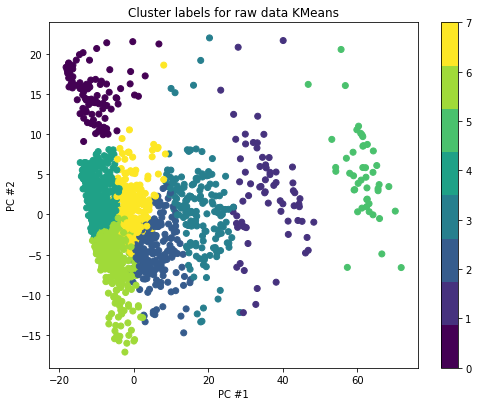

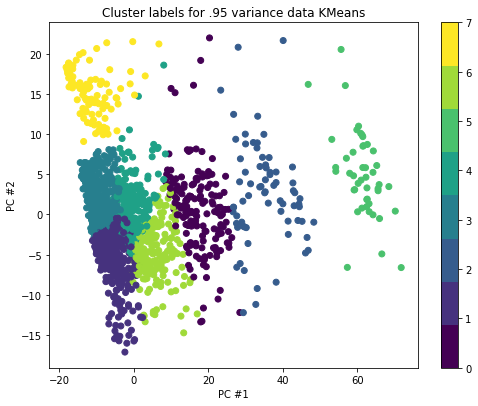

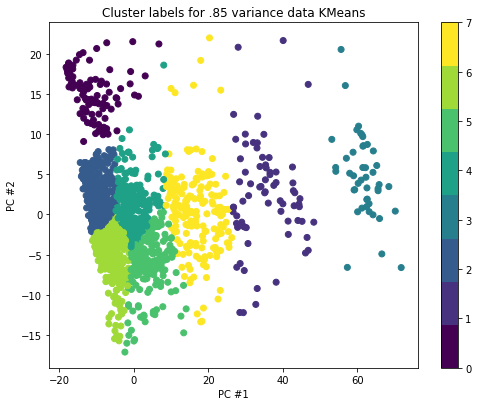

In [ ]:
from sklearn.cluster import KMeans

# Use Elbow method to find out the optimal # of clusters
"""
K = range(2,30)
sum_of_squared_dis = []
for k in K:
  km = KMeans(n_clusters=k, random_state=0)
  km = km.fit(pca_df)
  sum_of_squared_dis.append(km.inertia_)

plt.plot(K, sum_of_squared_dis, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum_of_squared_dis')
plt.title('Elbow Method For Optimal # of clusters - Raw')
plt.show()

sum_of_squared_dis = []
for k in K:
  km = KMeans(n_clusters=k, random_state=0)
  km = km.fit(pca_95_df)
  sum_of_squared_dis.append(km.inertia_)

plt.plot(K, sum_of_squared_dis, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum_of_squared_dis')
plt.title('Elbow Method For Optimal # of clusters - PCA reduced .95')
plt.show()

sum_of_squared_dis = []
for k in K:
  km = KMeans(n_clusters=k, random_state=0)
  km = km.fit(pca_85_df)
  sum_of_squared_dis.append(km.inertia_)

plt.plot(K, sum_of_squared_dis, 'bx-')
plt.xlabel('# of clusters')
plt.ylabel('sum_of_squared_dis')
plt.title('Elbow Method For Optimal # of clusters - PCA reduced .85')
plt.show()
"""

# From the elbow method graph, raw data, .85 variance pca reduced and .95 variance pca reduced data seem have the same trend, all can be clustered with 8 clusters 

clusters = 8
kmeans_raw = KMeans(n_clusters=clusters, random_state=0)
kmeans_raw.fit(pca_df)
y_pred_raw = kmeans_raw.predict(pca_df)

kmeans_95 = KMeans(n_clusters=clusters, random_state=0)
kmeans_95.fit(pca_95_df)
y_pred_95 = kmeans_95.predict(pca_95_df)

kmeans_85 = KMeans(n_clusters=clusters, random_state=0)
kmeans_85.fit(pca_85_df)
y_pred_85 = kmeans_85.predict(pca_85_df)

# Plot 3 scatter plots in 2d with components from pca_85_df, 1st: raw data clustering, 2nd: .95 variance clustering, 3rd: .85 variance clustering

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
sc = axes.scatter(pca_85_df[:,0], pca_85_df[:,1], c=y_pred_raw, cmap=plt.cm.get_cmap('viridis',8))
plt.colorbar(sc)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for raw data KMeans")
plt.show()


fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
sc = axes.scatter(pca_85_df[:,0], pca_85_df[:,1], c=y_pred_95, cmap=plt.cm.get_cmap('viridis',8))
plt.colorbar(sc)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for .95 variance data KMeans")
plt.show()

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
sc = axes.scatter(pca_85_df[:,0], pca_85_df[:,1], c=y_pred_85, cmap=plt.cm.get_cmap('viridis',8))
plt.colorbar(sc)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("Cluster labels for .85 variance data KMeans")
plt.show()

# Task 3 - Supervised Learning

We will first extract our symptoms as features, and use our last column of hospitalized new cases as output.

Then, we select best features from our dataset that we will train the models on.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.tree import DecisionTreeRegressor


percentile = 4
# extract symptom rows to use as a feature vector
#features_symptoms = merged.to_numpy()[:,2:-2]
features_symptoms = merged.iloc[:,2:-2]
# extract hospitalization_new as a 1d output array
hospitalization_new = np.array(merged.to_numpy()[:,-1:].flatten().tolist())

#select the best features
selection = SelectPercentile(f_regression,percentile=percentile)
x = selection.fit_transform(features_symptoms, hospitalization_new)

features_chosen = features_symptoms.columns.values[np.asarray(selection.get_support())]
print(len(features_chosen), "features chosen: ", features_chosen)

features_symptoms = x
print(features_symptoms.shape)

n_neighbors_range = list(range(1,math.ceil(features_symptoms.shape[0] / 2)))
p_range=list(range(1,2))
weight_range=["uniform", "distance"]
criterion_range=["mse","mae"]
max_depth_range=list(range(1,40))

17 features chosen:  ['Ageusia' 'Anosmia' 'Burning Chest Pain' 'Chills' 'Dysgeusia' 'Eye pain'
 'Hypoxemia' 'Low-grade fever' 'Nasal congestion' 'Pneumonia'
 'Post-nasal drip' 'Pulmonary edema' 'Shallow breathing' 'Shivering'
 'Shortness of breath' 'Stomach rumble' 'Wheeze']
(805, 17)


We will now define a few functions that help find the best hyperparameters for our models, given a cross validation split. 

We use the GridSearchCV to exhaustively check for best possible hyperparameters. GridSearchCV performs cross validation given the splits defined in its parameters. 

We have three such functions: 
1. Tune for scaled KNN
2. Tune for scaled Decision Tree
3. Tune for unscaled Decision Tree

In [ ]:
### BEST HYPERPARAMS FOR SCALED  KNN###
def find_best_hyperparams_scaled_knn(xTrain, yTrain,cv):
  """ Finds best values for knn hyperparameters based on feature input """

  clf = GridSearchCV(KNeighborsRegressor(), dict(n_neighbors=n_neighbors_range, p=p_range, weights=weight_range),cv=cv)
  #Fit the model
  x = RobustScaler().fit_transform(xTrain)
  x = PCA(n_components="mle", svd_solver="full").fit_transform(x)
  best_model = clf.fit(xTrain,yTrain)
  
  n_neighbors= best_model.best_estimator_.get_params()['n_neighbors']
  weight = best_model.best_estimator_.get_params()['weights']
  p = best_model.best_estimator_.get_params()['p']

  return best_model.best_estimator_.get_params()

In [ ]:
### BEST HYPERPARAMS FOR UNSCALED DATA TREE ###

def find_best_hyperparams_unscaled_decTree(xTrain, yTrain,cv):
  """ Finds best values for DecisionTree hyperparameters (unscaled) based on feature input """

  clf = GridSearchCV(DecisionTreeRegressor(), dict(max_depth=max_depth_range, criterion=criterion_range),cv=cv)
  #Fit the model
  best_model = clf.fit(xTrain, yTrain)

  max_depth_unscaled = best_model.best_estimator_.get_params()['max_depth']
  criterion_unscaled = best_model.best_estimator_.get_params()['criterion']

  return best_model.best_estimator_.get_params()

In [ ]:
### BEST HYPERPARAMS FOR TREE SCALED###

def find_best_hyperparams_scaled_decTree(xTrain, yTrain,cv):

  clf = GridSearchCV(DecisionTreeRegressor(), dict(max_depth=max_depth_range, criterion=criterion_range),cv=cv)
  #Fit the model
  x = StandardScaler().fit_transform(xTrain)
  x = PCA(n_components="mle", svd_solver="full").fit_transform(x)
  best_model = clf.fit(xTrain,yTrain)
  
  max_depth_scaled = best_model.best_estimator_.get_params()['max_depth']
  criterion_scaled = best_model.best_estimator_.get_params()['criterion']

  return best_model.best_estimator_.get_params()

Now we will define utility functions that help create our models. 
These functions find best hyperparameters, then create a replica of the desired model with the most optimum parameters found.

In [ ]:
# Utility functions to get scaled models with best hyperparameters

def create_scaled_knn(xTrain, yTrain,cv=None):
  params = find_best_hyperparams_scaled_knn(xTrain, yTrain,cv)
  
  # create a model and scale it
  knn = KNeighborsRegressor()
  knn.set_params(**(params))
  scaled_knn = make_pipeline(RobustScaler(), PCA(n_components="mle", svd_solver="full"), knn)

  return scaled_knn

def create_scaled_decTree(xTrain,yTrain,cv=None):
  params = find_best_hyperparams_scaled_decTree(xTrain, yTrain,cv)

  dec_tree = DecisionTreeRegressor()
  dec_tree.set_params(**(params))
  scaled_dec_tree = make_pipeline(RobustScaler(), PCA(n_components="mle", svd_solver="full"), dec_tree)

  return scaled_dec_tree

def create_unscaled_decTree(xTrain,yTrain,cv=None):
  params = find_best_hyperparams_unscaled_decTree(xTrain,yTrain,cv)
  
  unscaled_dec_tree = DecisionTreeRegressor()
  unscaled_dec_tree.set_params(**(params))

  return unscaled_dec_tree

Now we will define regions for our cross validation and call our utility functions that will cross-validate, tune hyperparameters, and return a scaled replica of the models with tuned hyperparameters.

To obey the region-based cross-validation split, we use the GroupShuffleSplit tool that ensures items within the same "group" are not split. The groups are got by the region codes.

In [ ]:
"""" CREATE ONE MODEL TUNED AND CROSS VALIDATED """""

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

# label each row in feature symptoms with corresponding group.
groups_region = pd.factorize(merged["open_covid_region_code"].tolist())[0]

# make a 80-20 train-validation set
gss_by_region = GroupShuffleSplit(n_splits=5,train_size=0.8)

splits = []
for train_idx, test_idx in gss_by_region.split(features_symptoms, hospitalization_new, groups_region):
  splits.append((train_idx,test_idx))

# Cross-Validate, Tune, and Scale the models
scaled_knn = create_scaled_knn(features_symptoms,hospitalization_new,splits)
scaled_dec_tree = create_scaled_decTree(features_symptoms, hospitalization_new,splits)
unscaled_dec_tree = create_unscaled_decTree(features_symptoms, hospitalization_new,splits)

GridSearchCV automatically cross-validates our models in finding the most optimal hyperparameters. We have created replicas of the models with the tuned hyperparameters, and will now run it across the train-validation splits used in cv to find the accuracy

Scaled KNN R^2:  0.5738089412386931
Scaled DecTree R^2:  -9.095690262612322
Unscaled DecTree R^2:  -9.672653488172026
---
Scaled KNN RMS:  468.1162750497795
Scaled DecTree RMS:  2278.345494746277
Unscaled DecTree RMS:  2342.5441138178126
---------------------------
Scaled KNN R^2:  0.10138129789613291
Scaled DecTree R^2:  -1.7161104099677784
Unscaled DecTree R^2:  -2.3786565732051335
---
Scaled KNN RMS:  1093.2237286679303
Scaled DecTree RMS:  1900.6188541409917
Unscaled DecTree RMS:  2119.7924841067993
---------------------------
Scaled KNN R^2:  0.04456687555105854
Scaled DecTree R^2:  0.22690561920317676
Unscaled DecTree R^2:  0.1990276872771929
---
Scaled KNN RMS:  2771.9978921514394
Scaled DecTree RMS:  2493.4979012324643
Unscaled DecTree RMS:  2538.0577562962935
---------------------------
Scaled KNN R^2:  0.1464865388831177
Scaled DecTree R^2:  0.012159326641686174
Unscaled DecTree R^2:  0.11868625975297231
---
Scaled KNN RMS:  654.5118191601176
Scaled DecTree RMS:  704.13471760

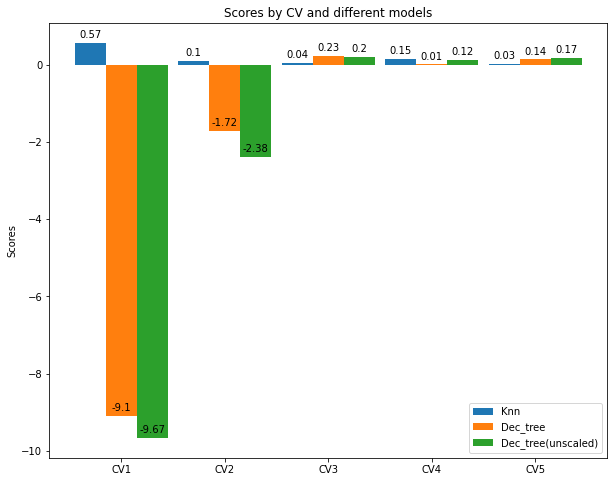

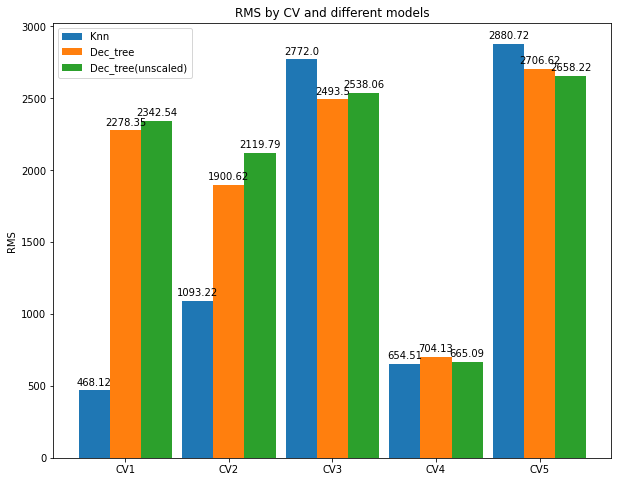

KNN Mean R2 0.178
KNN Mean RMS 1573.714
Decision Tree Mean R2 -2.088
Decision Tree Mean RMS 2016.6439999999998
Unscaled decision Tree Mean R2 -2.3120000000000003
Unscaled decision Tree Mean RMS 2064.74


In [ ]:
knn_r2s = []
scaled_dec_r2s = []
unscaled_dec_r2s = []

knn_rms = []
scaled_dec_rms = []
unscaled_dec_rms = []

for train_idx, test_idx in splits:
  xTrain = features_symptoms[train_idx]
  yTrain = hospitalization_new[train_idx]
  xTest = features_symptoms[test_idx]
  yTest = hospitalization_new[test_idx]

  # fit data
  scaled_knn.fit(xTrain, yTrain)
  scaled_dec_tree.fit(xTrain, yTrain)
  unscaled_dec_tree.fit(xTrain,yTrain)

  # generate predictions for validation set
  scaled_knn_predictions = scaled_knn.predict(xTest)
  scaled_dec_tree_predictions = scaled_dec_tree.predict(xTest)
  unscaled_dec_tree_predictions = unscaled_dec_tree.predict(xTest)

  # get accuracy metrics
  scaled_knn_r2 = scaled_knn.score(xTest,yTest)
  scaled_dec_tree_r2 = scaled_dec_tree.score(xTest,yTest)
  unscaled_dec_tree_r2 = unscaled_dec_tree.score(xTest,yTest)

  # append to list for later graphs
  knn_r2s.append(round(scaled_knn_r2, 2))
  scaled_dec_r2s.append(round(scaled_dec_tree_r2, 2))
  unscaled_dec_r2s.append(round(unscaled_dec_tree_r2, 2))
  knn_rms.append(round(sqrt(mean_squared_error(yTest,scaled_knn_predictions)), 2))
  scaled_dec_rms.append(round(sqrt(mean_squared_error(yTest,scaled_dec_tree_predictions)) , 2))
  unscaled_dec_rms.append(round(sqrt(mean_squared_error(yTest,unscaled_dec_tree_predictions)), 2))

  print("Scaled KNN R^2: ", scaled_knn_r2)
  print("Scaled DecTree R^2: ", scaled_dec_tree_r2)
  print("Unscaled DecTree R^2: ", unscaled_dec_tree_r2)
  print("---")
  print("Scaled KNN RMS: ", sqrt(mean_squared_error(yTest,scaled_knn_predictions)))
  print("Scaled DecTree RMS: ", sqrt(mean_squared_error(yTest,scaled_dec_tree_predictions)))
  print("Unscaled DecTree RMS: ", sqrt(mean_squared_error(yTest,unscaled_dec_tree_predictions)))
  print("---------------------------")

# Results visualization
labels = ['CV1', 'CV2', 'CV3', 'CV4', 'CV5']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, knn_r2s, width, label='Knn')
rects2 = ax.bar(x, scaled_dec_r2s, width, label='Dec_tree')
rects3 = ax.bar(x + width, unscaled_dec_r2s, width, label='Dec_tree(unscaled)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by CV and different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()
########################
fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, knn_rms, width, label='Knn')
rects2 = ax.bar(x, scaled_dec_rms, width, label='Dec_tree')
rects3 = ax.bar(x + width, unscaled_dec_rms, width, label='Dec_tree(unscaled)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMS')
ax.set_title('RMS by CV and different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.show()

print("KNN Mean R2", np.mean(knn_r2s))
print("KNN Mean RMS", np.mean(knn_rms))
print("Decision Tree Mean R2", np.mean(scaled_dec_r2s))
print("Decision Tree Mean RMS", np.mean(scaled_dec_rms))
print("Unscaled decision Tree Mean R2", np.mean(unscaled_dec_r2s))
print("Unscaled decision Tree Mean RMS", np.mean(unscaled_dec_rms))

Let's repeat the same process, but this time splitting by date. 

We will keep data after '2020-08-10' as validation, and the rest for training.

In [ ]:
validation_date = "2020-08-10"

merged_reset = merged.reset_index()
train_idx  = merged_reset.index[merged['date'] < validation_date].tolist()
test_idx = merged_reset.index[merged['date'] >= validation_date].tolist()

xTrain, yTrain, xTest, yTest = features_symptoms[train_idx], hospitalization_new[train_idx], features_symptoms[test_idx], hospitalization_new[test_idx]

splits = [(train_idx,test_idx)]

scaled_knn = create_scaled_knn(features_symptoms,hospitalization_new,splits)
scaled_dec_tree = create_scaled_decTree(features_symptoms, hospitalization_new,splits)
unscaled_dec_tree = create_unscaled_decTree(features_symptoms, hospitalization_new,splits)

# fit data
scaled_knn.fit(xTrain, yTrain)
scaled_dec_tree.fit(xTrain, yTrain)
unscaled_dec_tree.fit(xTrain,yTrain)

# generate predictions for validation set
scaled_knn_predictions = scaled_knn.predict(xTest)
scaled_dec_tree_predictions = scaled_dec_tree.predict(xTest)
unscaled_dec_tree_predictions = unscaled_dec_tree.predict(xTest)

# get accuracy metrics
scaled_knn_r2 = scaled_knn.score(xTest,yTest)
scaled_dec_tree_r2 = scaled_dec_tree.score(xTest,yTest)
unscaled_dec_tree_r2 = unscaled_dec_tree.score(xTest,yTest)

print("Scaled KNN R^2: ", scaled_knn_r2)
print("Scaled DecTree R^2: ", scaled_dec_tree_r2)
print("Unscaled DecTree R^2: ", unscaled_dec_tree_r2)
print("---")
print("Scaled KNN RMS: ", sqrt(mean_squared_error(yTest,scaled_knn_predictions)))
print("Scaled DecTree RMS: ", sqrt(mean_squared_error(yTest,scaled_dec_tree_predictions)))
print("Unscaled DecTree RMS: ", sqrt(mean_squared_error(yTest,unscaled_dec_tree_predictions)))
print("---------------------------")

Scaled KNN R^2:  0.521884123594826
Scaled DecTree R^2:  -11.023447931952669
Unscaled DecTree R^2:  0.6043315719106694
---
Scaled KNN RMS:  283.2545157177684
Scaled DecTree RMS:  1420.44614714689
Unscaled DecTree RMS:  257.6771796942546
---------------------------
